<a href="https://colab.research.google.com/github/esfandiaryfard/3D-Image-Synthesis-for-Medical-Applications/blob/main/FFR_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-video
!pip install monai
from google.colab import drive
drive = drive.mount('/content/drive')



batchsize = 4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.5 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 86/86 [00:00<00:00, 79609.39it/s]


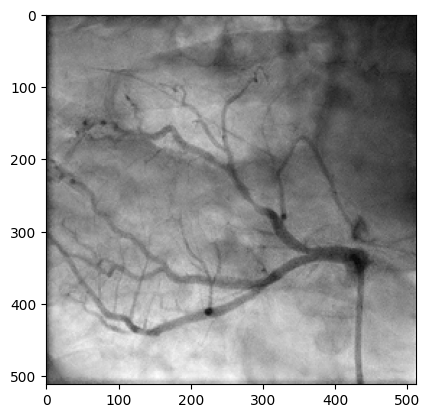

In [2]:
import sys
import os
import json
from torch.utils.data import DataLoader
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose,
    MapTransform,
    AddChannelD,
    RepeatChannelD,
    LoadImageD,
    ScaleIntensityD,
    NormalizeIntensityD,
    RandFlipD,
    RandRotate90D,
    ResizeD,
    ResizeWithPadOrCropD,
    ToTensorD)
from monai.config import KeysCollection
import copy
import argparse

class AppendRootDirD(MapTransform):
    def __init__(self, keys: KeysCollection, root_dir):
        super().__init__(keys)
        self.root_dir = root_dir
    
    def __call__(self, data):
        d = copy.deepcopy(data)
        for k in self.keys:
            d[k] = os.path.join(self.root_dir,d[k])
        return d

class FFRDataset3D(CacheDataset):
    def __init__(self, root_dir, split_path, transforms, cache_num = sys.maxsize, cache_rate=1.0, num_workers=1):    
        if not os.path.isdir(root_dir):
            raise ValueError("Root directory root_dir must be a directory.")
        
        with open(split_path) as fp:
           data=json.load(fp)

        transforms_comp = Compose([
            AppendRootDirD('image', root_dir),
            transforms,
            ])
        super().__init__(data, transforms_comp, cache_num=cache_num, cache_rate=cache_rate, num_workers=num_workers)

def get_loader(args):
    transforms = Compose([
        LoadImageD(['image']),
        AddChannelD(['image']),
        ResizeD(['image'], spatial_size = args.resize),
        ScaleIntensityD(['image']),
        NormalizeIntensityD(
            ['image'], 
            subtrahend=args.mean, 
            divisor=args.std, 
            channel_wise=True
            ),
        ResizeWithPadOrCropD(['image'], spatial_size=args.pad, method="end"),
        ToTensorD(['image']),
        RandFlipD(['image'], prob = 0.5, spatial_axis=1),
        RandFlipD(['image'], prob = 0.5, spatial_axis=2),
        RandRotate90D(['image'], prob = 0.5, spatial_axes=(1,2))
        ])

    dataset = FFRDataset3D(
        root_dir = args.root_dir, 
        split_path = args.split_path, 
        transforms = transforms
        )
    
    loader = DataLoader(dataset,
                        batch_size = args.batch_size,
                        num_workers=0,
                        shuffle=args.shuffle)

    return loader

import matplotlib.pyplot as plt
if __name__ == '__main__':
    args={}
    args['resize'] = (-1,512,512) # dataset max 256x256
    args['pad'] = (50,512,512)
    args['mean'] = (0.5505,)
    args['std'] = (0.1740,)
    args['root_dir'] = os.path.join('drive/MyDrive/dataset/')
    args['split_path'] = os.path.join('drive/MyDrive/dataset/dataset.json')
    args['batch_size'] = batchsize
    args['shuffle'] = True
    args = argparse.Namespace(**args)

    # Dataset e Loader
    loader = get_loader(args)

    # Get samples
    tmp = next(iter(loader))
    plt.imshow(tmp['image'][1].numpy()[:,29,:,:].transpose(1,2,0).squeeze(), cmap="gray") 
    plt.show()